In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

Тест на равенство средней. Выборки А и В содержат непрерывные случайные величины. Выборки размеров n и m, со средним значением - a и b.

Гипотезы.
H0: выбрки А и В из одного распределения
H1: из разных распределений

In [2]:
def resample_diff(A, B):
    c = np.hstack((A, B))
    A = pd.Series(c).sample(len(A), replace=True)
    B = pd.Series(c).sample(len(B), replace=True)
    return abs(A.mean() - B.mean())
    
def evaluate_pvals(a, b, n, m, N):
    pvals = []

    for _ in tqdm(range(N)):
        A = np.random.normal(a, 1, n)
        B = np.random.normal(b, 1, m)

        # фиксируем различие
        diff = abs(A.mean() - B.mean())

        # как часто различие будет равно и больше при многократном семплировании из выборки A+B
        pval = np.mean([resample_diff(A, B) >= diff for _ in range(N)])
        pvals.append(pval) 
    
    return pvals

In [3]:
n = 700 # размер выборки А
m = 300 # размер выборки В

a = 70  # среднее выборки А
b = a + 0.1   # среднее выборки В

N = 200

# многократно семплируя наблюдения (эксперимент Монте Карло) считаем число превышений заданной
# конверсии, это и есть p-value
pvals = evaluate_pvals(a, b, n, m, N)

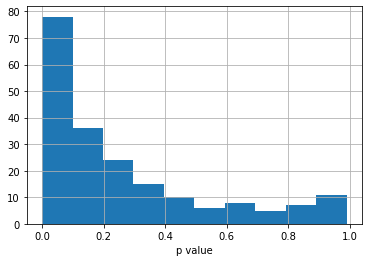

In [4]:
# распределение значения p
pd.Series(pvals).hist()
plt.xlabel("p value")
plt.show()

Значение p сконцентрировано у 0, значит выборки из разных распределений. Тогда определим мощность теста (power) для порога значимости alpha.

In [5]:
alpha = 0.05 # порог значимости, ложные срабатывания, ошибка I рода
power = np.mean(np.array(pvals) < alpha)
power

0.255

Полученная мощность теста ниже 0.80 (80%). Чтобы увеличить мощность теста необходимо увеличить размер выборок n и m.

Построим ROC кривую для проведенного теста

In [6]:
def plot_ROC(pvals, N, power, alpha):
    np.array(pvals.sort())
    df = pd.DataFrame({"pvals": pvals, "TPR": [i / N for i in range(N)]})
    
    df.plot(x="pvals", y="TPR", label="ROC")
    plt.plot([alpha, alpha], [0, 1], "k", label="alpha")
    plt.plot([0, alpha], [power, power], label="Power")
    plt.ylabel("TPR, recall, sencitivity, Power")
    plt.xlabel("FPR")
    plt.title("ROC")
    plt.legend()
    plt.show()

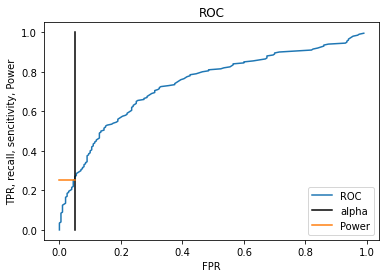

In [7]:
plot_ROC(pvals, N, power, alpha)

Также нужно провести А/А тест (sanity test) для проверки применимости теста на имеющихся данных.

In [8]:
pvals = evaluate_pvals(a, a, n, n, N)

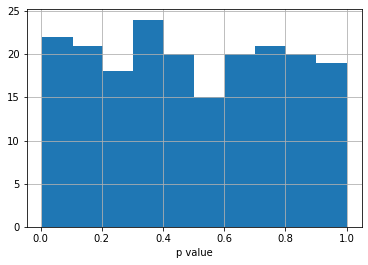

In [9]:
# распределение значения p
pd.Series(pvals).hist()
plt.xlabel("p value")
plt.show()

Распределение знаяения p равномерно, а уровень False Positive на уровне alpha значит на данных можно применять статистические тесты.

In [10]:
alpha = 0.05
FP = np.mean(np.array(pvals) < alpha)
FP

0.045

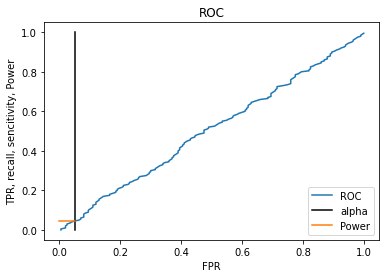

In [11]:
plot_ROC(pvals, N, FP, alpha)

Применим несколько тетстов из библиотек чтобы проверить наши выводы, сделанные из эксперимента Монте Карло

In [12]:
from scipy import stats

In [151]:
# тест на нормальность распределения
# если p-value > alpha, то далее сравниваем выборки по средним арифметическим
# t-критерием Стьюдента
# если нет, то сравниваем по медианам критерием Манна-Уитни

In [152]:
# H0: распределение нормальное

In [153]:
N = 1000
A = np.random.normal(a, 1, N*n).reshape(N, n)
B = np.random.normal(b, 1, N*m).reshape(N, m)

# Shapiro-Wilka
# pvals = list(map(lambda x: stats.shapiro(x).pvalue, A))
# pvals = list(map(lambda x: stats.shapiro(x).pvalue, B))

# D’Agostino and Pearson’s
# pvals = list(map(lambda x: stats.normaltest(x).pvalue, A))
pvals = list(map(lambda x: stats.normaltest(x).pvalue, B))

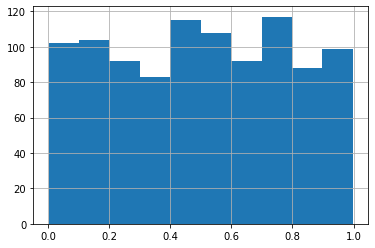

In [154]:
pd.Series(pvals).hist()

In [155]:
alpha = 0.05
FP = np.mean(np.array(pvals) < alpha)
FP

0.055

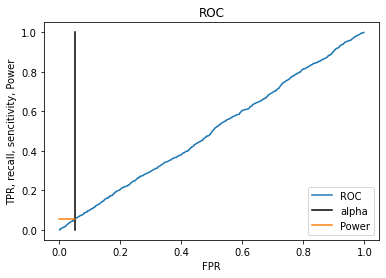

In [156]:
plot_ROC(pvals, N, FP, alpha)

FP равен порогу значиомсти 0.05, значит Но не отвергаем. Распределение нормально

In [157]:
# тест на скошенность и эксцесс как у нормального распределения

pvals = list(map(lambda x: stats.kurtosistest(x).pvalue, B))

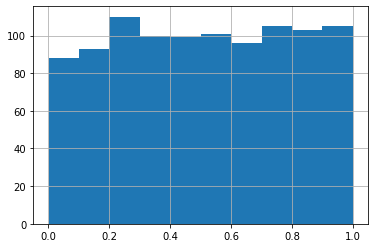

In [158]:
pd.Series(pvals).hist()

In [ ]:
"Shapiro-Wilka normality test": stats.shapiro,
"D’Agostino and Pearson’s normality test": stats.normaltest,
"Skew test": stats.skewtest,
"Kurtosis test": stats.kurtosistest,
"Mann-Whitneyu test for medians": stats.mannwhitneyu,
"Mood test for medians": stats.median_test,
"Mood test for same distribution": stats.mood,

In [46]:
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats

In [29]:
statistics, pval = proportions_ztest([a, b], [n, m])
pval

0.007035346384355496

In [41]:
A = np.random.binomial(1, a / n, n)
B = np.random.binomial(1, b / m, m)

t-test

In [42]:
statistic, pvalue = scipy.stats.ttest_ind(A, B, equal_var=False)
pvalue

0.012790519837178249

Mann-Whitneyu test

In [45]:
statistic, pvalue = scipy.stats.mannwhitneyu(A, B, alternative="two-sided")
pvalue

0.006886901229230957

p value ниже порога значимости alpha (0.05) а значит различие в конверсиях a и b выборок A и B не случайно.

Многократное семплирование (эксперимент Монте-Карло) можно сделать через lambda функцию

In [74]:
A = np.random.binomial(1, a/n, n*N).reshape(N, n)
B = np.random.binomial(1, b/m, m*N).reshape(N, m)

In [80]:
tt_pvalues = list(map(lambda x: scipy.stats.ttest_ind(x[0], x[1]).pvalue, zip(A, B)))
mw_pvalues = list(map(lambda x: scipy.stats.mannwhitneyu(x[0], x[1]).pvalue, zip(A, B)))

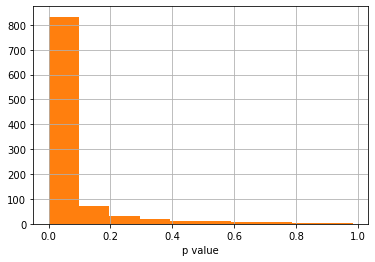

In [81]:
# распределение значения p
pd.Series(tt_pvalues).hist()
pd.Series(mw_pvalues).hist()
plt.xlabel("p value")
plt.show()

In [83]:
# мощности тестов
np.mean(np.array(tt_pvalues) < alpha), np.mean(np.array(mw_pvalues) < alpha)

(0.755, 0.755)